# Phys 581 Winter 2019
# Assignment #4: Neural Networks
## Alexander Hickey, 10169582

In [1]:
#Must be running Python 3.6!
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]'

In [2]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Dense
%matplotlib inline

Using TensorFlow backend.


### Introduction

Inspired by biological neural networks, a method of machine learning known as deep learning has revolutionized the way that scientists model complex systems. In general, a neural network is a collection of connected nodes (or *neurons*) that can transmit data through their connections (or *edges*). Typically, the neurons are oraganized into layers, each of which can perform different kings of transformations on their inputs. Additionally, each of the edges are assigned a weight that increases or decreases the strength of a signal at an edge, and these weights are adjusted in the learning process using a set of training data. The term *deep* neural network refers to a neural network with more than one hidden layer (see Figure below).

![Deep neural network](http://neuralnetworksanddeeplearning.com/images/tikz41.png)

(Image source: http://neuralnetworksanddeeplearning.com/chap6.html)

The Lorenz equations are:

\begin{align*}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-y \\
\frac{dz}{dt} &= xy-\beta z
\end{align*}

Generate a 3-d time series for the Lorenz equations with parameters selected to produce "butterfly" strange attractors.

In [3]:
import scipy.integrate

def dfunc(state, t0, sigma=10.0, beta=8/3.0, rho=58.0):
    '''
    This function defines the 3D Lorenz system:
    dx/dt = sigma*(y-x)
    dy/dt = x*(rho-z)-y
    dz/dt = x*y-beta*z
    
    
    return [dx/dt,dy/dt,dz/dt]
    '''
    
    x, y, z = state
    
    return np.array([ sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

t0, tf, tstep = 0.0, 20.0, 9999
tvals = np.linspace(t0, tf, tstep)

#Initial state set to [1,1,1]
xyz_0 = np.ones(3)
xyz = scipy.integrate.odeint( dfunc, xyz_0, tvals )

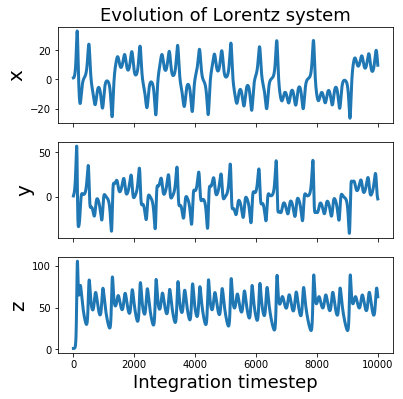

In [4]:
#Plot x,y,z components of Lorentz system from t=0 to t=2-
fig, ax = plt.subplots(3, sharex=True, figsize=(6,6))
ax[0].plot( xyz[:,0], lw=3 )
ax[0].set_ylabel('x',fontsize=20)
ax[1].plot( xyz[:,1], lw=3 )
ax[1].set_ylabel('y',fontsize=20)
ax[2].plot( xyz[:,2], lw=3 )
ax[2].set_ylabel('z',fontsize=20)

ax[0].set_title('Evolution of Lorentz system',fontsize=18) 
ax[-1].set_xlabel('Integration timestep',fontsize=18)

plt.show()

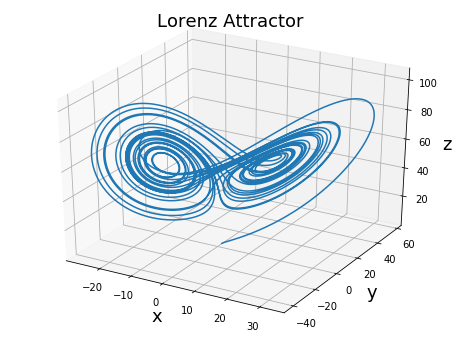

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18)
ax.set_zlabel('z',fontsize=18)
ax.set_title('Lorenz Attractor',fontsize=18)

ax.plot(*xyz.T)
plt.show()

### Deep learning

###### Build a simple model to use current state at time `T` to predict future state at time `T + dt`

We begin by defining the model in the Keras framework. In particular, this means defining the particular topology of the deep learning network.

In [6]:
#Fix random seed
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

#Create model
model = Sequential()
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear')) #sigmoid'))

#Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 11)                99        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 21        
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [7]:
stack = []
ndt = 99  #future prediction time shift
L = 900 #Length of timestep interval
vs = 5000 #Starting point of validation interval

#Model will attempt to shift data set by a timestep of ndt
#i.e. use points [0:900] to predict points [99:999]
for epoch in range(999):
    
    # take one step
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=1, batch_size=100, verbose=0) # initial_epoch=epoch

    # calculate prediction quality for training data
    rms_training = np.sqrt( np.mean( (xyz[ndt:L+ndt,:] - model.predict(xyz[:L]) )**2 ) )
    
    # calculate prediction quality for distant future data
    rms_validate = np.sqrt( np.mean( (xyz[vs+ndt:vs+L+ndt,:] - model.predict(xyz[vs:vs+L]) )**2 ) )   
    
    #Record root mean square error for each epoch
    stack.append([rms_training, rms_validate])
    
stack = np.array(stack)

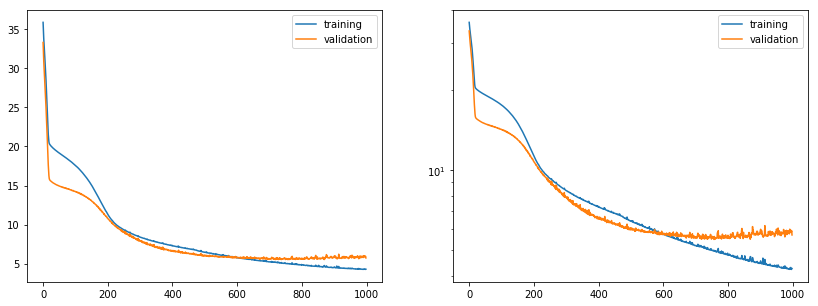

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plt.sca(axes[0])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.legend(loc=0)

plt.sca(axes[1])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.legend(loc=0)
plt.yscale('log')

The fit to the training data decreases rapidly, with some quasi-plateaus.  The validation fit also improves, and at times is significantly better than the training results.  They eventually appear to converge, which is a pleasant surprise.

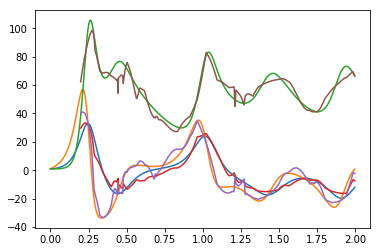

In [9]:
# Predicted and actual time series for the training data appear to agree very well.
#
plt.plot(tvals[:L+ndt], xyz[:L+ndt,:])
plt.plot( tvals[ndt:L+ndt], model.predict( xyz[:L]) )

plt.show()

The fit to the entire sequence appears to be surprisingly good.

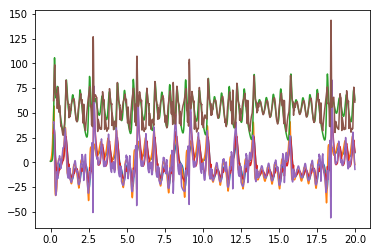

In [10]:
plt.plot(tvals[0:9900+ndt], xyz[0:9900+ndt,:])
plt.plot( tvals[ndt:9900+ndt], model.predict(xyz[0:9900]) )

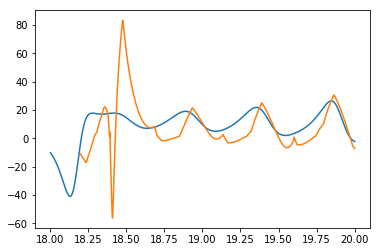

In [11]:
#zoom in on tail end of validation region
#
plt.plot( tvals[9000:9900+ndt], xyz[9000:9900+ndt,1])
plt.plot( tvals[9000+ndt:9900+ndt], model.predict(xyz[9000:9900,:]).T[1] ) 

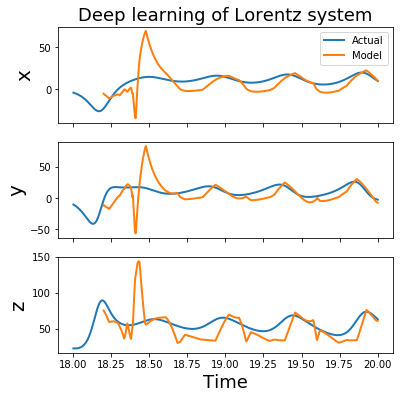

In [12]:
 

ax[1].plot(tvals[9000:9900+ndt], xyz[9000:9900+ndt:,1], lw=2 )
ax[1].plot(tvals[9000+ndt:9900+ndt], model.predict(xyz[9000:9900,:]).T[1], lw=2)
ax[1].set_ylabel('y',fontsize=20)

ax[2].plot(tvals[9000:9900+ndt], xyz[9000:9900+ndt:,2], lw=2)
ax[2].plot(tvals[9000+ndt:9900+ndt], model.predict(xyz[9000:9900,:]).T[2], lw=2 )
ax[2].set_ylabel('z',fontsize=20)

ax[0].set_title('Deep learning of Lorentz system',fontsize=18) 
ax[-1].set_xlabel('Time',fontsize=18)

ax[0].legend(loc=0)
plt.show()

## Assignment

#### The validation curve appears to fluctuate more than the training curve at later epochs.  Discuss why this might be.


The fact that fluctuations begin to appear at later epochs suggests that the fluctuations are a remenant of over-fitting. Overfitting occurs frequently in data-fitting techniques, such as least-squares regression, as the algorithm attempts to fit the "noise" as well.

Problems arise to to predicting chaos.

#### Tidy up code (eg. factor out magic numbers like 9000:9900) and make sure it is correct.

#### How does prediction quality decrease for larger `ndt` ie. further into the future?

In [25]:
def create_model(nodes=[8,11,6]):
    
    #Create model
    model = Sequential()
    
    #Define input layer
    model.add(Dense(nodes[0], input_dim=3, activation='relu'))
    
    #Define "deep" layers
    for n in nodes[1:]:
        
        model.add(Dense(n, activation='relu'))
    
    #Define output layer
    model.add(Dense(3, activation='linear')) #sigmoid'))

    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model,ndt,xyz,L=900,epochs=999):
    
    history = model.fit(xyz[:L],xyz[ndt:L+ndt], epochs=epochs, batch_size=100, verbose=0)
    
    return model

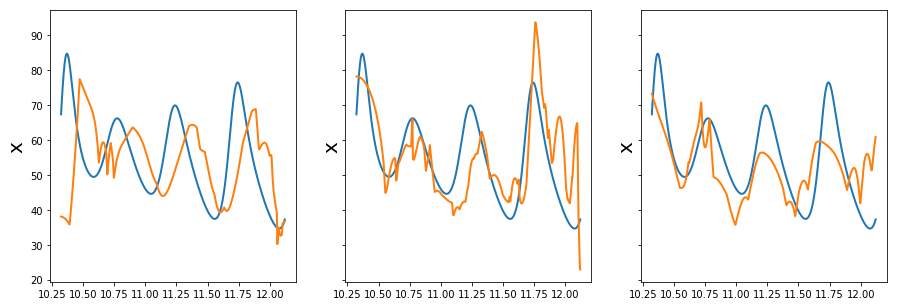

In [37]:
L = 900 #Length of timestep interval
vs = 5000 #Starting point of validation interval
ker = train_model(create_model(),ndt,xyz)

fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,5))
ndtl = [99,149,199]

for j in range(len(ndtl)):
    
    ker = train_model(create_model(),ndtl[j],xyz)
    ax[j].plot(tvals[vs+ndt:vs+L+ndt], xyz[vs+ndt:vs+L+ndt:,2], lw=2,label='Actual')
    ax[j].plot(tvals[vs+ndt:vs+L+ndt], ker.predict(xyz[vs:vs+L,:]).T[2], lw=2 ,label='Model')
    ax[j].set_ylabel('x',fontsize=20)

#### Explore changing hyper parameters (the number of layers, nodes per layer etc.) to improve prediction quality

### Optional

#### How does prediction quality decrease for smaller block sizes (eg.100 instead of 900)?

#### Explore the use of "lag vectors" as inputs

For example, take a 1000x3 vector and rearrange it to 500x6 by grouping pairs of state vectors together.  

    xyz[0:999,:].reshape(-1,6)